# Kernel Bottleneck Analysis Methodology

This notebook documents the methodology used to compute normalized performance metrics, bottleneck flags, and composite scores from the profiling data in [op_tests/moe_benchmarking_profiling/results/profiling/kernels_with_counters.csv](op_tests/moe_benchmarking_profiling/results/profiling/kernels_with_counters.csv).

**Goal:** Identify which kernels and configurations are likely suffering

## Acronym Reference

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **SQ** | Sequencer | Shader sequencer that manages wave execution |
| **CU** | Compute Unit | Basic compute block containing SIMDs, LDS, and scheduler |
| **SIMD** | Single Instruction Multiple Data | Vector execution unit within a CU (4 SIMDs per CU on MI300X) |
| **SE** | Shader Engine | Group of CUs (MI300X has 4 SEs per XCC) |
| **XCC** | Accelerated Compute Die | Chiplet containing multiple SEs (MI300X has 8 XCCs) |
| **TCC** | Texture Cache Controller | L2 cache controller (16 instances per XCC) |
| **TCP** | Texture Cache Per-pipe | L1 vector cache (one per CU) |
| **LDS** | Local Data Share | On-chip shared memory per workgroup (64KB per CU) |
| **MFMA** | Matrix Fused Multiply-Add | Matrix core instructions for GEMM operations |
| **VALU** | Vector ALU | Vector arithmetic logic unit |
| **SALU** | Scalar ALU | Scalar arithmetic logic unit |
| **GRBM** | Graphics Register Bus Manager | Manages GPU-wide registers and timing |
| **GUI** | GPU Interface | Active GPU execution interface |
| **EA** | Efficiency Arbiter | Memory controller interface |
| **HBM** | High Bandwidth Memory | GPU main memory (HBM3 on MI300X) |
| **OI** | Operational Intensity | FLOPs per byte of memory traffic |

### MI300X Hardware Summary
- **8 XCCs** (chiplets) × **4 SEs** × **~38 CUs per SE** = **304 CUs total**
- **4 SIMDs per CU** = **1216 SIMDs total** (SIMD_NUM)
- **16 TCC instances per XCC** = L2 cache partitions
- **64 KB LDS per CU**, **32 KB L1 per CU**

## 1) Inputs and Required Counters

The CSV contains per-kernel profiling results with key counters from rocprofv3. The methodology relies on these fields:

### ⚠️ Important: Counter Aggregation

Many rocprofv3 counters are internally multi-dimensional (e.g., per-SE, per-XCC, per-TCC instance). When rocprofv3 collects these counters:

- **Counters with `_sum` suffix** (e.g., `TCP_PENDING_STALL_CYCLES_sum`, `TCC_TAG_STALL_sum`, `SQ_WAVES_sum`): Explicitly reduced using `reduce(counter,sum)` expression. These are **already summed** across all hardware instances.

- **Counters without `_sum` suffix** (e.g., `SQ_WAVE_CYCLES`, `SQ_WAIT_ANY`, `TCC_HIT`, `TCC_MISS`): When requested as a single counter (not per-dimension), rocprofv3 **returns the aggregated/summed value** by default. The CSV contains single values, confirming aggregation.

- **Derived metrics** (e.g., `MfmaUtil`, `OccupancyPercent`, `LDSBankConflict`, `MemUnitStalled`): Computed by rocprofv3 using expressions that include `reduce(...,sum)` or `reduce(...,max)` and normalization by `CU_NUM`, `SE_NUM`, or `SIMD_NUM`. These are **already normalized** percentages or ratios.

### Timing
- **`time_us`**: Kernel execution time in microseconds

### Memory Traffic (KB) — Aggregated across all memory channels
- **`FETCH_SIZE`**: Total kilobytes fetched from video memory.
- **`WRITE_SIZE`**: Total kilobytes written to video memory. 

### L2 Cache (TCC) Counters — Aggregated across 16 TCC instances × 8 XCCs
- **`TCC_HIT`**: Number of L2 cache hits (summed across all TCC instances)
- **`TCC_MISS`**: Number of L2 cache misses (summed across all TCC instances)
- **`TCC_TAG_STALL_sum`**: Total cycles L2 tag pipeline stalled. *Explicit sum: `reduce(TCC_TAG_STALL,sum)`*

### L1 Cache (TCP) Stall Counters — Aggregated across TCP instances
- **`TCP_PENDING_STALL_CYCLES_sum`**: Stall cycles waiting for L2 data. *Explicit sum: `reduce(TCP_PENDING_STALL_CYCLES,sum)`*

### Wave/CU Cycle Counters — Aggregated across 4 SEs × 8 XCCs (units: quad-cycles = 4 GPU cycles)
- **`SQ_WAVE_CYCLES`**: Cycles spent executing waves in CUs. Reported per-SE but aggregated when requested as single value. Nondeterministic.
- **`SQ_WAIT_ANY`**: Wave-cycles spent waiting for anything. Units in quad-cycles.
- **`SQ_BUSY_CU_CYCLES`**: Quad-cycles each CU is busy. Per-SE aggregated.

### LDS Counters — Aggregated across SEs
- **`SQ_INSTS_LDS`**: Total LDS instructions issued (including FLAT). Per-SE aggregated.
- **`SQ_LDS_BANK_CONFLICT`**: Number of LDS bank conflicts (count). Per-SE aggregated.
- **`SQ_LDS_IDX_ACTIVE`**: LDS index active cycles. Per-SE aggregated.
- **`LDSBankConflict`**: **Derived % metric** = `100 * reduce(SQ_LDS_BANK_CONFLICT,sum) / reduce(GRBM_GUI_ACTIVE,max) / CU_NUM`. Value 0–100%.

### Compute Utilization — Derived metrics (already normalized)
- **`MfmaUtil`**: MFMA utilization as fraction (0–1). *Expression: `reduce(SQ_VALU_MFMA_BUSY_CYCLES,sum) / (reduce(GRBM_GUI_ACTIVE,max) * SIMD_NUM) * 100`* — but CSV stores as 0–1, so we multiply by 100.
- **`SQ_INSTS_MFMA`**: Total MFMA instructions issued. Per-SE aggregated.
- **`MFMA_FLOPS`**: Total MFMA floating-point operations. *rocprofv3: `(MOPS_F16 + MOPS_BF16 + MOPS_F32 + MOPS_F64) * 512`*

### Occupancy and Memory Stalls — Derived metrics (already normalized)
- **`OccupancyPercent`**: GPU occupancy as % of maximum. *Expression: `400 * reduce(SQ_WAVE_CYCLES,sum) / reduce(GRBM_GUI_ACTIVE,max) / CU_NUM / 32`*
- **`MemUnitStalled`**: % of GPUTime memory unit stalled (0=optimal, 100=bad). *Expression: `100 * TCP_TCP_TA_DATA_STALL_CYCLES_max / reduce(GRBM_GUI_ACTIVE,max) / SE_NUM`*

We derive additional normalized rates/percentages that are comparable across kernels with different sizes and runtimes.

## 2) Normalization Strategy

Raw counters scale with runtime and work size. To compare kernels fairly, we normalize counters into comparable percentages and ratios.

### 2.1 rocprofv3 Derived Metrics (used directly)
These metrics are already computed by rocprofv3 as percentages (0–100%):

- **Memory stall percentage** (`mem_stall_pct`)
  $$\text{mem\_stall\_pct} = \text{MemUnitStalled}$$
  **Units:** percent (0–100, clipped)  
  **Why:** Measures % of time memory unit is stalled. High values mean memory-induced blocking.

- **LDS bank conflict percentage** (`lds_bank_conflict_pct`)
  $$\text{lds\_bank\_conflict\_pct} = \text{LDSBankConflict}$$
  **Units:** percent (0–100)  
  **Why:** rocprofv3 computes `100 * SQ_LDS_BANK_CONFLICT / GRBM_GUI_ACTIVE / CU_NUM`.

- **Occupancy** (`occupancy_pct`)
  $$\text{occupancy\_pct} = \text{OccupancyPercent}$$
  **Units:** percent  
  **Why:** Low occupancy reduces latency hiding. rocprofv3: `400 * SQ_WAVE_CYCLES / GRBM_GUI_ACTIVE / CU_NUM / 32`.

- **MFMA utilization** (`mfma_util_pct`)
  $$\text{mfma\_util\_pct} = \text{MfmaUtil}$$
  **Units:** percent (0–100, clipped)  
  **Why:** rocprofv3 already provides 0–100%. Low values mean matrix cores are underused.

### 2.2 Instruction-based ratios

- **LDS conflicts per LDS instruction**
  $$\text{lds\_conflict\_per\_lds\_inst} = \frac{\text{SQ\_LDS\_BANK\_CONFLICT}}{\text{SQ\_INSTS\_LDS}}$$
  **Units:** conflicts/instruction (dimensionless)  
  **Why:** Indicates average bank conflicts per LDS instruction. Values > 1 mean multiple conflicts per access.

- **LDS conflict severity** (scaled to 0–100)
  $$\text{lds\_conflict\_severity} = \min\left(\frac{\text{lds\_conflict\_per\_lds\_inst}}{10} \times 100, 100\right)$$
  **Units:** percent (0–100)  
  **Why:** Normalizes conflicts/inst to a 0–100 scale where 10 conflicts/inst = 100% severity.

### 2.3 Cycle-based percentages

- **TCP stall percentage** (L1→L2 stalls as % of GPU capacity)
  $$\text{tcp\_stall\_pct} = \frac{\text{TCP\_PENDING\_STALL\_CYCLES\_sum}}{\text{GRBM\_GUI\_ACTIVE} \times \text{CU\_NUM}} \times 100$$
  **Units:** percent  
  **Why:** Normalizes by total GPU CU-cycles. High values mean L1→L2 latency dominates.

- **TCC miss rate** (L2 cache effectiveness)
  $$\text{tcc\_miss\_rate} = \frac{\text{TCC\_MISS}}{\text{TCC\_HIT} + \text{TCC\_MISS}} \times 100$$
  **Units:** percent  
  **Why:** Shows L2 cache hit rate. High miss rate suggests poor locality or large working set.

- **Wait cycles percentage** (wave wait time)
  $$\text{wait\_cycles\_pct} = \frac{\text{SQ\_WAIT\_ANY}}{\text{SQ\_WAVE\_CYCLES}} \times 100$$
  **Units:** percent  
  **Why:** Fraction of wave cycles spent waiting. `SQ_WAIT_ANY` counts quad-cycles waiting for anything.

- **TCC tag stall percentage** (L2 tag contention)
  $$\text{tcc\_tag\_stall\_pct} = \frac{\text{TCC\_TAG\_STALL\_sum}}{\text{GRBM\_GUI\_ACTIVE}} \times 100$$
  **Units:** percent  
  **Why:** Normalizes by GPU-active cycles. High values indicate L2 tag pipeline contention.

- **CU busy percentage** (compute unit utilization)
  $$\text{cu\_busy\_pct} = \frac{\text{SQ\_BUSY\_CU\_CYCLES}}{\text{GRBM\_GUI\_ACTIVE} \times \text{CU\_NUM}} \times 100$$
  **Units:** percent  
  **Why:** Fraction of CU-cycles where CUs are actively working. Low values (<50%) indicate CUs are often idle.

### 2.4 Inverted Metrics for Visualization

For consistent heatmap coloring where **high values always mean \"bad\"** (red in RdYlGn_r colormap), we compute inverted versions:

- **Occupancy deficit**: $\text{occupancy\_deficit} = 100 - \text{occupancy\_pct}$ — Higher = worse (more underutilized)
- **MFMA idle percentage**: $\text{mfma\_idle\_pct} = 100 - \text{mfma\_util\_pct}$ — Higher = worse (matrix cores idle)
- **CU idle percentage**: $\text{cu\_idle\_pct} = 100 - \text{cu\_busy\_pct}$ — Higher = worse (CUs idle)

### 2.5 Derived performance quantities

- **Operational Intensity**
  $$\text{OI} = \frac{\text{MFMA\_FLOPS}}{(\text{FETCH\_SIZE} + \text{WRITE\_SIZE}) \times 1024}$$
  **Units:** FLOP/Byte  
  **Why:** Lower OI typically implies memory-bound behavior. Ridge point = Peak_TFLOPS / Peak_BW.

- **MFMA TFLOPs/s**
  $$\text{tflops\_mfma} = \frac{\text{MFMA\_FLOPS}}{\text{time\_us} \times 10^{6}}$$
  **Units:** TFLOP/s  
  **Why:** Delivered matrix throughput from MFMA operations.

- **Bandwidth (GB/s)**
  $$\text{bandwidth\_gb} = \frac{(\text{FETCH\_SIZE} + \text{WRITE\_SIZE}) \times 1024}{\text{time\_us} \times 1000}$$
  **Units:** GB/s  
  **Why:** Actual memory bandwidth from hardware counters. FETCH_SIZE and WRITE_SIZE are in KB.

In [5]:
import pandas as pd
import numpy as np

In [6]:
INPUT_FILE = "results/profiling/kernels_with_counters.csv"
df = pd.read_csv(INPUT_FILE)

# Remove bad data: config 1102 has corrupted counter values
bad_configs = [1102]
df = df[~df["config_idx"].isin(bad_configs)].reset_index(drop=True)
print(f"Loaded {len(df)} rows (removed configs: {bad_configs})")
df.head()

Loaded 2894 rows (removed configs: [1102])


,config_idx,token,model_dim,inter_dim,expert,topk,act_type,dtype,q_dtype_a,q_dtype_w,...,MemUnitStalled,SQ_INSTS_LDS,SQ_INSTS_MFMA,SQ_INSTS_VALU,SQ_LDS_BANK_CONFLICT,SQ_LDS_IDX_ACTIVE,SQ_WAIT_ANY,SQ_WAVES_sum,SQ_WAVE_CYCLES,MFMA_FLOPS
0,0,1,7168,256,256,8,ActivationType.Silu,torch.bfloat16,torch.float8_e4m3fnuz,torch.float8_e4m3fnuz,...,0.003978,8640.0,57344.0,154896.0,0.0,61056.0,2929077.0,2048.0,3780562.0,9.395241e+08
1,0,1,7168,256,256,8,ActivationType.Silu,torch.bfloat16,torch.float8_e4m3fnuz,torch.float8_e4m3fnuz,...,0.012207,16576.0,28672.0,215488.0,315392.0,439040.0,4770223.0,1792.0,6353959.0,4.697620e+08
2,1,1,7168,256,257,9,ActivationType.Silu,torch.bfloat16,torch.float8_e4m3fnuz,torch.float8_e4m3fnuz,...,0.003921,9720.0,64512.0,171778.0,0.0,68688.0,2617385.0,2056.0,3480750.0,1.056965e+09
3,1,1,7168,256,257,9,ActivationType.Silu,torch.bfloat16,torch.float8_e4m3fnuz,torch.float8_e4m3fnuz,...,0.012397,18648.0,32256.0,242424.0,354816.0,493920.0,5305241.0,2016.0,7392042.0,5.284823e+08
4,2,2,7168,256,256,8,ActivationType.Silu,torch.bfloat16,torch.float8_e4m3fnuz,torch.float8_e4m3fnuz,...,0.003933,17280.0,114688.0,289392.0,0.0,122112.0,3082258.0,2056.0,4332231.0,1.879048e+09


### Cell 3: Normalize Raw Counters

This cell computes all normalized metrics from raw counters:

1. **Time-based rates**: `mem_stall_rate`, `lds_bank_conflict_rate` — stall frequency per microsecond
2. **Instruction-based ratios**: `lds_conflict_per_lds_inst` — fraction of LDS instructions with bank conflicts
3. **Cycle-based percentages**: `tcp_stall_pct`, `tcc_miss_rate`, `wait_cycles_pct` — how cycles are spent
4. **CU busy percentage**: Uses `SQ_BUSY_CU_CYCLES` if available
5. **Compute metrics**: `mfma_util_pct`, `occupancy_pct` — scaled to 0–100%
6. **Derived performance**: `OI` (FLOP/Byte), `tflops_mfma`, `bandwidth_gb`

The small epsilon (`1e-9`) prevents division by zero.

In [17]:
# Normalize and derive metrics for bottleneck analysis
df_n = df.copy()

# MI300X hardware constants
CU_NUM = 304
SE_NUM = 32   # 4 SEs × 8 XCCs
SIMD_NUM = 1216  # 4 SIMDs per CU

# --- rocprofv3 derived metrics (already 0-100%) ---
df_n["occupancy_pct"] = df_n["OccupancyPercent"]
df_n["lds_bank_conflict_pct"] = df_n["LDSBankConflict"]
df_n["mfma_util_pct"] = df_n["MfmaUtil"].clip(upper=100)
df_n["mem_stall_pct"] = df_n["MemUnitStalled"].clip(upper=100)

# --- Cache metrics ---
df_n["tcc_miss_rate"] = (df_n["TCC_MISS"] / (df_n["TCC_HIT"] + df_n["TCC_MISS"] + 1e-9)) * 100

# --- Cycle-based metrics ---
# TCP stall: summed across CUs, normalize by total CU-cycles
df_n["tcp_stall_pct"] = (df_n["TCP_PENDING_STALL_CYCLES_sum"] / (df_n["GRBM_GUI_ACTIVE"] * CU_NUM + 1e-9)) * 100
# Wait cycles as fraction of wave cycles
df_n["wait_cycles_pct"] = (df_n["SQ_WAIT_ANY"] / (df_n["SQ_WAVE_CYCLES"] + 1e-9)) * 100
# TCC tag stall
df_n["tcc_tag_stall_pct"] = (df_n["TCC_TAG_STALL_sum"] / (df_n["GRBM_GUI_ACTIVE"] + 1e-9)) * 100
# CU busy: fraction of CU-cycles where CUs are working
df_n["cu_busy_pct"] = (df_n["SQ_BUSY_CU_CYCLES"] / (df_n["GRBM_GUI_ACTIVE"] * CU_NUM + 1e-9)) * 100

# --- LDS conflict metrics ---
# Conflicts per instruction (can be >1 with 32 banks)
df_n["lds_conflict_per_lds_inst"] = df_n["SQ_LDS_BANK_CONFLICT"] / (df_n["SQ_INSTS_LDS"] + 1e-9)
# Severity scaled to 0-100 (10 conflicts/inst → 100%)
df_n["lds_conflict_severity"] = (df_n["lds_conflict_per_lds_inst"] / 10 * 100).clip(0, 100)

# --- Performance metrics ---
df_n["OI"] = df_n["MFMA_FLOPS"] / ((df_n["FETCH_SIZE"] + df_n["WRITE_SIZE"]) * 1024 + 1e-9)
df_n["tflops_mfma"] = df_n["MFMA_FLOPS"] / df_n["time_us"] / 1e6
df_n["bandwidth_gb"] = ((df_n["FETCH_SIZE"] + df_n["WRITE_SIZE"]) * 1024) / df_n["time_us"] / 1000

# --- Inverted metrics for heatmaps (high = bad, for consistent colormap) ---
df_n["cu_idle_pct"] = 100 - df_n["cu_busy_pct"]           # CU idle time (high = bad)
df_n["occupancy_deficit"] = 100 - df_n["occupancy_pct"]  # Occupancy gap (high = bad)
df_n["mfma_idle_pct"] = 100 - df_n["mfma_util_pct"]      # MFMA idle time (high = bad)

# Summary statistics
print("=== Normalized Metric Distributions ===\\n")
for m in ["tcc_miss_rate", "tcp_stall_pct", "mem_stall_pct", "wait_cycles_pct",
          "occupancy_pct", "mfma_util_pct", "lds_bank_conflict_pct", "lds_conflict_severity", "cu_busy_pct"]:
    v = df_n[m].dropna()
    print(f"{m}: min={v.min():.2f}, max={v.max():.2f}, median={v.median():.2f}")


=== Normalized Metric Distributions ===\n
tcc_miss_rate: min=6.21, max=99.52, median=95.55
tcp_stall_pct: min=0.01, max=21.95, median=5.56
mem_stall_pct: min=0.00, max=0.94, median=0.01
wait_cycles_pct: min=2.38, max=96.55, median=65.26
occupancy_pct: min=0.02, max=85.52, median=8.71
mfma_util_pct: min=0.01, max=73.44, median=5.68
lds_bank_conflict_pct: min=0.00, max=43.10, median=0.42
lds_conflict_severity: min=0.00, max=100.00, median=5.25
cu_busy_pct: min=0.02, max=25.47, median=7.77


In [8]:
# Quantile analysis for threshold tuning
print("=== Metric Percentiles ===\n")
metrics = ["tcc_miss_rate", "tcp_stall_pct", "wait_cycles_pct", 
           "occupancy_pct", "mfma_util_pct", "lds_conflict_severity", "cu_busy_pct"]

for m in metrics:
    if m in df_n.columns:
        d = df_n[m].dropna()
        print(f"{m}:")
        print(f"  25th={d.quantile(0.25):.2f}, 50th={d.median():.2f}, 75th={d.quantile(0.75):.2f}, 90th={d.quantile(0.90):.2f}")
        print()

=== Metric Percentiles ===

tcc_miss_rate:
  25th=86.89, 50th=95.55, 75th=97.77, 90th=98.65

tcp_stall_pct:
  25th=2.28, 50th=5.56, 75th=8.63, 90th=9.52

wait_cycles_pct:
  25th=48.49, 50th=65.26, 75th=76.89, 90th=88.17

occupancy_pct:
  25th=4.08, 50th=8.71, 75th=17.51, 90th=34.83

mfma_util_pct:
  25th=3.78, 50th=5.68, 75th=10.42, 90th=16.98

lds_conflict_severity:
  25th=0.00, 50th=5.25, 75th=89.16, 90th=100.00

cu_busy_pct:
  25th=4.07, 50th=7.77, 75th=10.47, 90th=11.39



### Cell 4: Apply Bottleneck Thresholds

Define heuristic thresholds and create boolean flags for each bottleneck category:

- **`memory_bottleneck`**: True if L2 miss rate >20% OR TCP stall >30% OR mem stall rate >0.5
- **`lds_bottleneck`**: True if >10% of LDS instructions have conflicts OR high conflict rate
- **`occupancy_bottleneck`**: True if occupancy <20%
- **`mfma_util_bottleneck`**: True if MFMA utilization <50%
- **`wait_stall_bottleneck`**: True if waves wait >40% of cycles
- **`cu_idle_bottleneck`**: True if CU busy <15% (CUs are mostly idle)

These flags make it easy to filter problematic kernels.

In [18]:
# Bottleneck thresholds (tuned based on observed distributions)
# Distributions: tcc_miss ~95%, tcp_stall ~5%, wait_cycles ~65%, occupancy ~9%, mfma_util ~6%
thresholds = {
    "tcc_miss_rate_high": 90.0,     # 90th percentile is ~99%, most kernels miss L2
    "tcp_stall_high": 15.0,        # Median ~5%, 15% is clearly problematic
    "mem_stall_high": 0.5,         # Very low values observed, keep threshold low
    "lds_conflict_severity_high": 50.0,  # Scaled 0-100, 50% = 5 conflicts/inst
    "lds_bank_conflict_pct_high": 10.0,  # % of LDS accesses with conflicts
    "occupancy_low": 15.0,         # Median ~9%, below 15% is problematic
    "mfma_util_low": 20.0,         # Median ~6%, below 20% is underutilized
    "wait_cycles_high": 80.0,      # Median ~65%, above 80% is excessive
    "cu_busy_low": 15.0            # Median ~8%, below 15% means CUs mostly idle
}

df_n["memory_bottleneck"] = (
    (df_n["tcc_miss_rate"] > thresholds["tcc_miss_rate_high"]) |
    (df_n["tcp_stall_pct"] > thresholds["tcp_stall_high"]) |
    (df_n["mem_stall_pct"] > thresholds["mem_stall_high"])
)

df_n["lds_bottleneck"] = (
    (df_n["lds_conflict_severity"] > thresholds["lds_conflict_severity_high"]) |
    (df_n["lds_bank_conflict_pct"] > thresholds["lds_bank_conflict_pct_high"])
)

df_n["occupancy_bottleneck"] = df_n["occupancy_pct"] < thresholds["occupancy_low"]
df_n["mfma_util_bottleneck"] = df_n["mfma_util_pct"] < thresholds["mfma_util_low"]
df_n["wait_stall_bottleneck"] = df_n["wait_cycles_pct"] > thresholds["wait_cycles_high"]
df_n["cu_idle_bottleneck"] = df_n["cu_busy_pct"] < thresholds["cu_busy_low"]

print("Bottleneck counts:")
for b in ["memory_bottleneck", "lds_bottleneck", "occupancy_bottleneck", "mfma_util_bottleneck", "wait_stall_bottleneck", "cu_idle_bottleneck"]:
    print(f"  {b}: {df_n[b].sum()} ({100*df_n[b].mean():.1f}%)")

Bottleneck counts:
  memory_bottleneck: 2057 (71.1%)
  lds_bottleneck: 958 (33.1%)
  occupancy_bottleneck: 2019 (69.8%)
  mfma_util_bottleneck: 2652 (91.6%)
  wait_stall_bottleneck: 581 (20.1%)
  cu_idle_bottleneck: 2868 (99.1%)


### Cell 5: Identify Primary Bottleneck

When a kernel has multiple bottlenecks, we determine which is **most severe** using a severity score:

- **Memory severity** = `tcc_miss_rate + tcp_stall_pct`
- **LDS severity** = `lds_conflict_severity`
- **Occupancy severity** = `100 - occupancy_pct`
- **MFMA severity** = `100 - mfma_util_pct`
- **Wait severity** = `wait_cycles_pct`
- **CU idle severity** = `100 - cu_busy_pct`

The bottleneck with the highest severity becomes the `primary_bottleneck`. This tells you what to fix first.

In [19]:
# Primary bottleneck selection based on severity
def primary_bottleneck(row):
    issues = []
    if row["memory_bottleneck"]:
        issues.append(("memory", row["tcp_stall_pct"] + row["mem_stall_pct"]))
    if row["lds_bottleneck"]:
        issues.append(("lds", row["lds_conflict_severity"]))
    if row["occupancy_bottleneck"]:
        issues.append(("occupancy", 100 - row["occupancy_pct"]))
    if row["mfma_util_bottleneck"]:
        issues.append(("mfma_util", 100 - row["mfma_util_pct"]))
    if row["wait_stall_bottleneck"]:
        issues.append(("wait_stall", row["wait_cycles_pct"]))
    if row["cu_idle_bottleneck"]:
        issues.append(("cu_idle", 100 - row["cu_busy_pct"]))
    if not issues:
        return "none"
    return max(issues, key=lambda x: x[1])[0]

df_n["primary_bottleneck"] = df_n.apply(primary_bottleneck, axis=1)
print("Primary bottleneck distribution:")
print(df_n["primary_bottleneck"].value_counts())

Primary bottleneck distribution:
primary_bottleneck
mfma_util     992
occupancy     691
cu_idle       651
lds           530
wait_stall     21
none            9
Name: count, dtype: int64


### Cell 6: Compute Composite Bottleneck Scores

Two scores are computed for different use cases:

#### `bottleneck_score` (includes LDS) — Use for CK kernels
$$\text{score} = 0.10 \times \text{tcp\_stall} + 0.15 \times \text{lds\_severity} + 0.20 \times (100 - \text{occupancy}) + 0.20 \times (100 - \text{mfma\_util}) + 0.15 \times \text{wait\_cycles} + 0.20 \times (100 - \text{cu\_busy})$$

#### `score_no_lds` (excludes LDS) — Use for ASM kernels
$$\text{score} = 0.15 \times \text{tcp\_stall} + 0.25 \times (100 - \text{occupancy}) + 0.25 \times (100 - \text{mfma\_util}) + 0.15 \times \text{wait\_cycles} + 0.20 \times (100 - \text{cu\_busy})$$

**Why two scores?** LDS conflicts are bimodal: CK kernels average 47% severity, ASM kernels have 0%. Using `bottleneck_score` for ASM would compress their score range and mask other issues.

**Interpretation (both scores):**
- **0–30**: Generally healthy
- **30–50**: Moderate issues
- **50–70**: Significant bottlenecks  
- **70–100**: Critical issues

In [20]:
# Composite bottleneck score (0-100, higher = worse)
# Weights sum to 1.0, each term contributes 0-100
df_n["bottleneck_score"] = (
    0.10 * df_n["tcp_stall_pct"].clip(0, 100) +
    0.15 * df_n["lds_conflict_severity"] +
    0.20 * (100 - df_n["occupancy_pct"]).clip(0, 100) +
    0.20 * (100 - df_n["mfma_util_pct"]).clip(0, 100) +
    0.15 * df_n["wait_cycles_pct"].clip(0, 100) +
    0.20 * (100 - df_n["cu_busy_pct"]).clip(0, 100)
)

# Alternative score excluding LDS (for ASM kernels where LDS=0)
# Reweighted to sum to 1.0
df_n["score_no_lds"] = (
    0.15 * df_n["tcp_stall_pct"].clip(0, 100) +
    0.25 * (100 - df_n["occupancy_pct"]).clip(0, 100) +
    0.25 * (100 - df_n["mfma_util_pct"]).clip(0, 100) +
    0.15 * df_n["wait_cycles_pct"].clip(0, 100) +
    0.20 * (100 - df_n["cu_busy_pct"]).clip(0, 100)
)

print("Bottleneck score distributions:")
print(f"  bottleneck_score: min={df_n['bottleneck_score'].min():.1f}, max={df_n['bottleneck_score'].max():.1f}, median={df_n['bottleneck_score'].median():.1f}")
print(f"  score_no_lds:     min={df_n['score_no_lds'].min():.1f}, max={df_n['score_no_lds'].max():.1f}, median={df_n['score_no_lds'].median():.1f}")
print()

# Show top problematic kernels
(df_n[["config_idx", "kernel_type", "stage", "token", "model_dim", "bottleneck_score", "score_no_lds", "primary_bottleneck"]]
 .sort_values("bottleneck_score", ascending=False)
 .head(20))

Bottleneck score distributions:
  bottleneck_score: min=41.8, max=86.2, median=69.1
  score_no_lds:     min=47.5, max=81.9, median=75.6



,config_idx,kernel_type,stage,token,model_dim,bottleneck_score,score_no_lds,primary_bottleneck
1771,1002,ck,stage1,8,2816,86.194151,81.209454,lds
1923,1066,ck,stage1,2,3328,86.111032,81.107883,lds
2070,1126,ck,stage1,2,3968,86.090726,81.079017,lds
2091,1134,ck,stage1,2,4096,86.083475,81.051102,lds
54,33,ck,stage1,16,4096,86.002861,80.942909,lds
1622,938,ck,stage1,8,2176,85.969356,80.948882,lds
2221,1186,ck,stage1,2,4736,85.958810,80.908289,lds
2625,1358,ck,stage1,1,7168,85.934274,80.919790,lds
52,32,ck,stage1,16,4096,85.933057,80.872219,lds
746,441,ck,stage2,1,256,85.908470,80.907545,lds


### Visualization: Bottleneck Analysis Plots

Useful visualizations for normalized metrics:
1. **By kernel_type** - Compare bottleneck patterns across gate, up, down, combine, sort kernels
2. **By stage** - Decode vs prefill behavior differences
3. **By primary_bottleneck** - Distribution of metrics within each bottleneck category
4. **By operational intensity (OI)** - Memory-bound vs compute-bound correlation

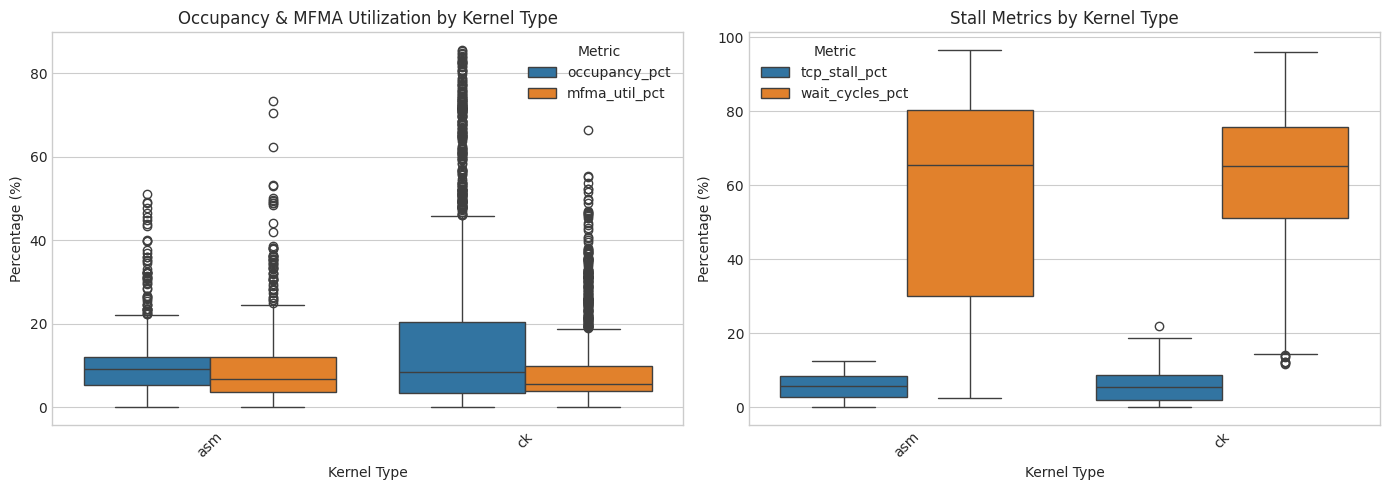

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
fig_size = (12, 5)

# Metrics to plot
metrics_to_plot = ["occupancy_pct", "mfma_util_pct", "tcp_stall_pct", 
                   "wait_cycles_pct", "lds_conflict_severity"]

# 1. Box plots by kernel_type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Occupancy and MFMA by kernel type
df_melt = df_n.melt(id_vars=["kernel_type"], value_vars=["occupancy_pct", "mfma_util_pct"],
                    var_name="metric", value_name="value")
sns.boxplot(data=df_melt, x="kernel_type", y="value", hue="metric", ax=axes[0])
axes[0].set_title("Occupancy & MFMA Utilization by Kernel Type")
axes[0].set_xlabel("Kernel Type")
axes[0].set_ylabel("Percentage (%)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title="Metric")

# Stall metrics by kernel type
df_melt2 = df_n.melt(id_vars=["kernel_type"], value_vars=["tcp_stall_pct", "wait_cycles_pct"],
                     var_name="metric", value_name="value")
sns.boxplot(data=df_melt2, x="kernel_type", y="value", hue="metric", ax=axes[1])
axes[1].set_title("Stall Metrics by Kernel Type")
axes[1].set_xlabel("Kernel Type")
axes[1].set_ylabel("Percentage (%)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Metric")

plt.tight_layout()
plt.show()

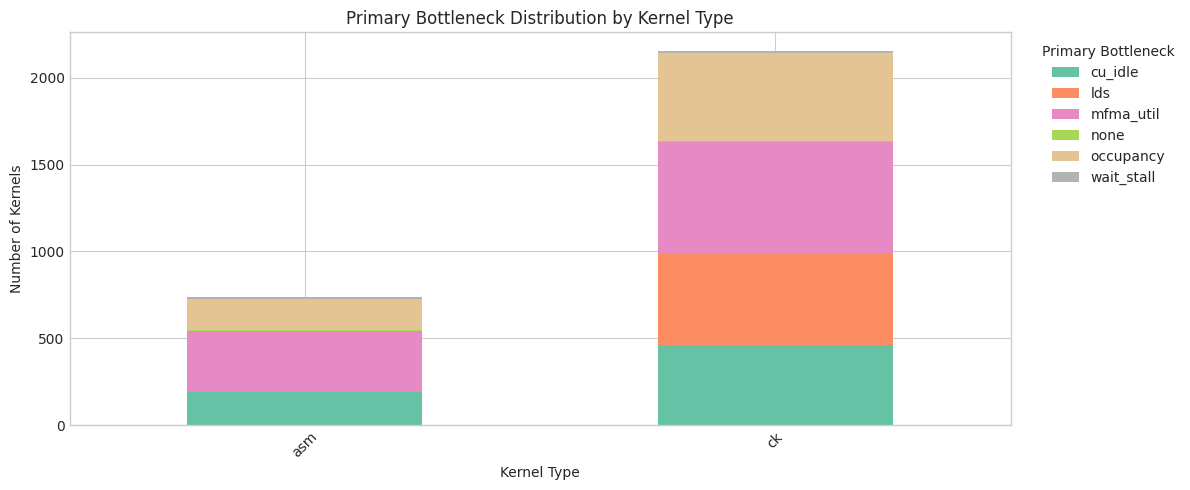

In [13]:
# 2. Primary bottleneck breakdown by kernel type (stacked bar)
fig, ax = plt.subplots(figsize=(12, 5))

bottleneck_counts = df_n.groupby(["kernel_type", "primary_bottleneck"]).size().unstack(fill_value=0)
bottleneck_counts.plot(kind="bar", stacked=True, ax=ax, colormap="Set2")
ax.set_title("Primary Bottleneck Distribution by Kernel Type")
ax.set_xlabel("Kernel Type")
ax.set_ylabel("Number of Kernels")
ax.legend(title="Primary Bottleneck", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

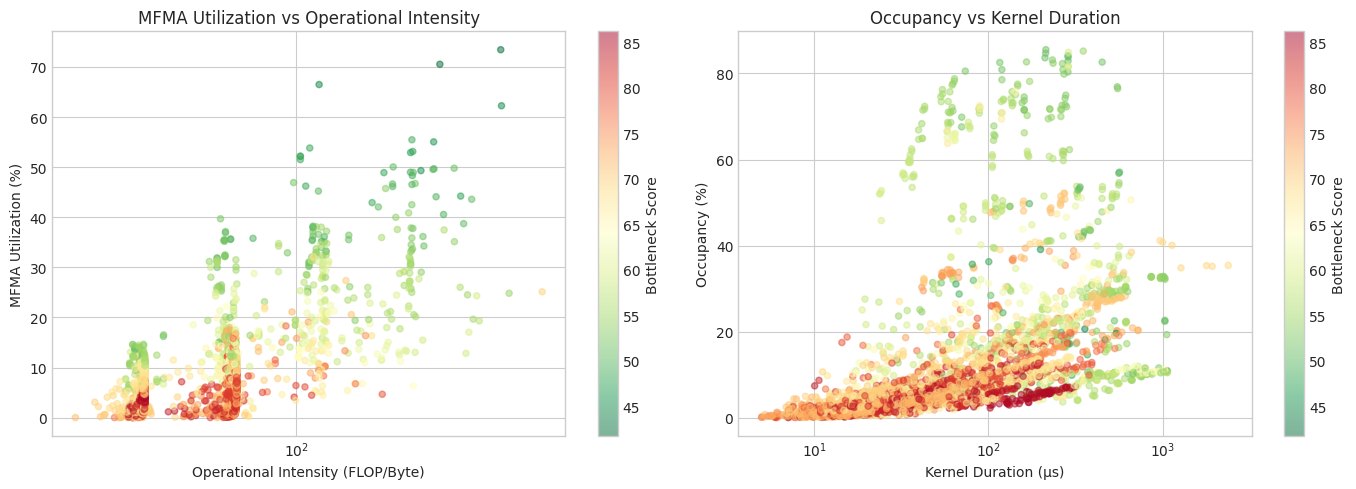

In [14]:
# 3. Metrics vs Operational Intensity (roofline-like scatter)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MFMA utilization vs OI - expect compute-bound (high OI) to have higher MFMA util
scatter = axes[0].scatter(df_n["OI"], df_n["mfma_util_pct"], 
                          c=df_n["bottleneck_score"], cmap="RdYlGn_r", 
                          alpha=0.5, s=20)
axes[0].set_xlabel("Operational Intensity (FLOP/Byte)")
axes[0].set_ylabel("MFMA Utilization (%)")
axes[0].set_title("MFMA Utilization vs Operational Intensity")
axes[0].set_xscale("log")
plt.colorbar(scatter, ax=axes[0], label="Bottleneck Score")

# Occupancy vs kernel duration - larger kernels should amortize launch overhead
scatter2 = axes[1].scatter(df_n["time_us"], df_n["occupancy_pct"],
                           c=df_n["bottleneck_score"], cmap="RdYlGn_r",
                           alpha=0.5, s=20)
axes[1].set_xlabel("Kernel Duration (µs)")
axes[1].set_ylabel("Occupancy (%)")
axes[1].set_title("Occupancy vs Kernel Duration")
axes[1].set_xscale("log")
plt.colorbar(scatter2, ax=axes[1], label="Bottleneck Score")

plt.tight_layout()
plt.show()

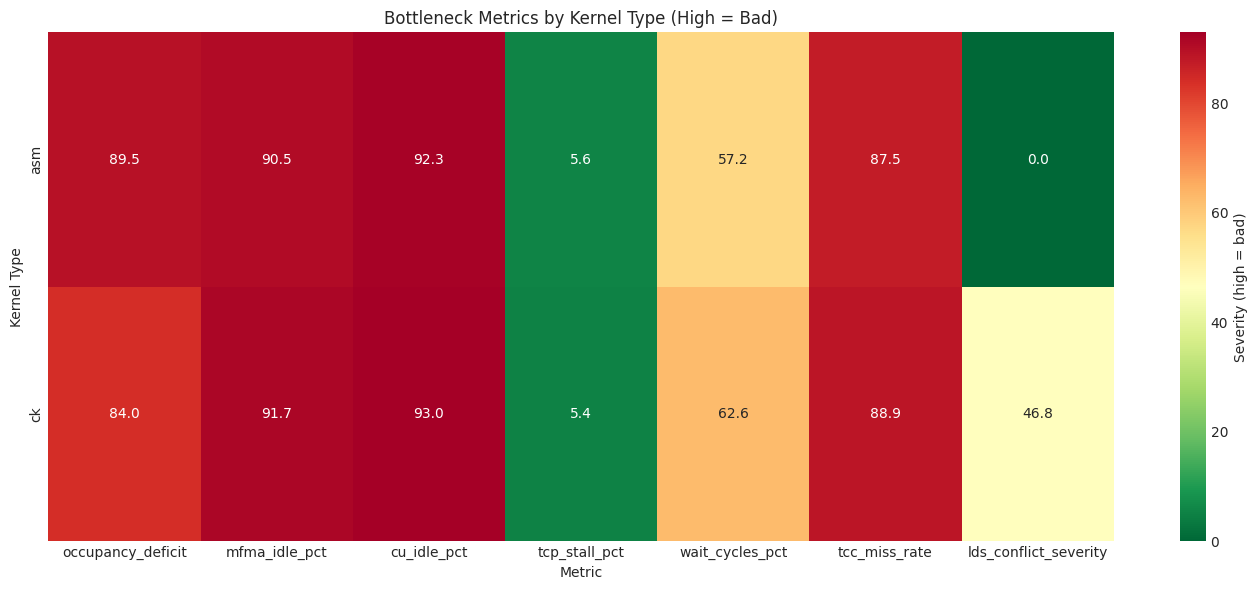

In [21]:
# 4. Heatmap: Average metrics by kernel_type (all metrics: high = bad)
fig, ax = plt.subplots(figsize=(14, 6))

# Use inverted metrics so high values consistently mean "bad" (red in RdYlGn_r)
heatmap_metrics = ["occupancy_deficit", "mfma_idle_pct", "cu_idle_pct",
                   "tcp_stall_pct", "wait_cycles_pct", "tcc_miss_rate", "lds_conflict_severity"]
heatmap_data = df_n.groupby("kernel_type")[heatmap_metrics].mean()

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=ax, 
            cbar_kws={"label": "Severity (high = bad)"})
ax.set_title("Bottleneck Metrics by Kernel Type (High = Bad)")
ax.set_xlabel("Metric")
ax.set_ylabel("Kernel Type")
plt.tight_layout()
plt.show()

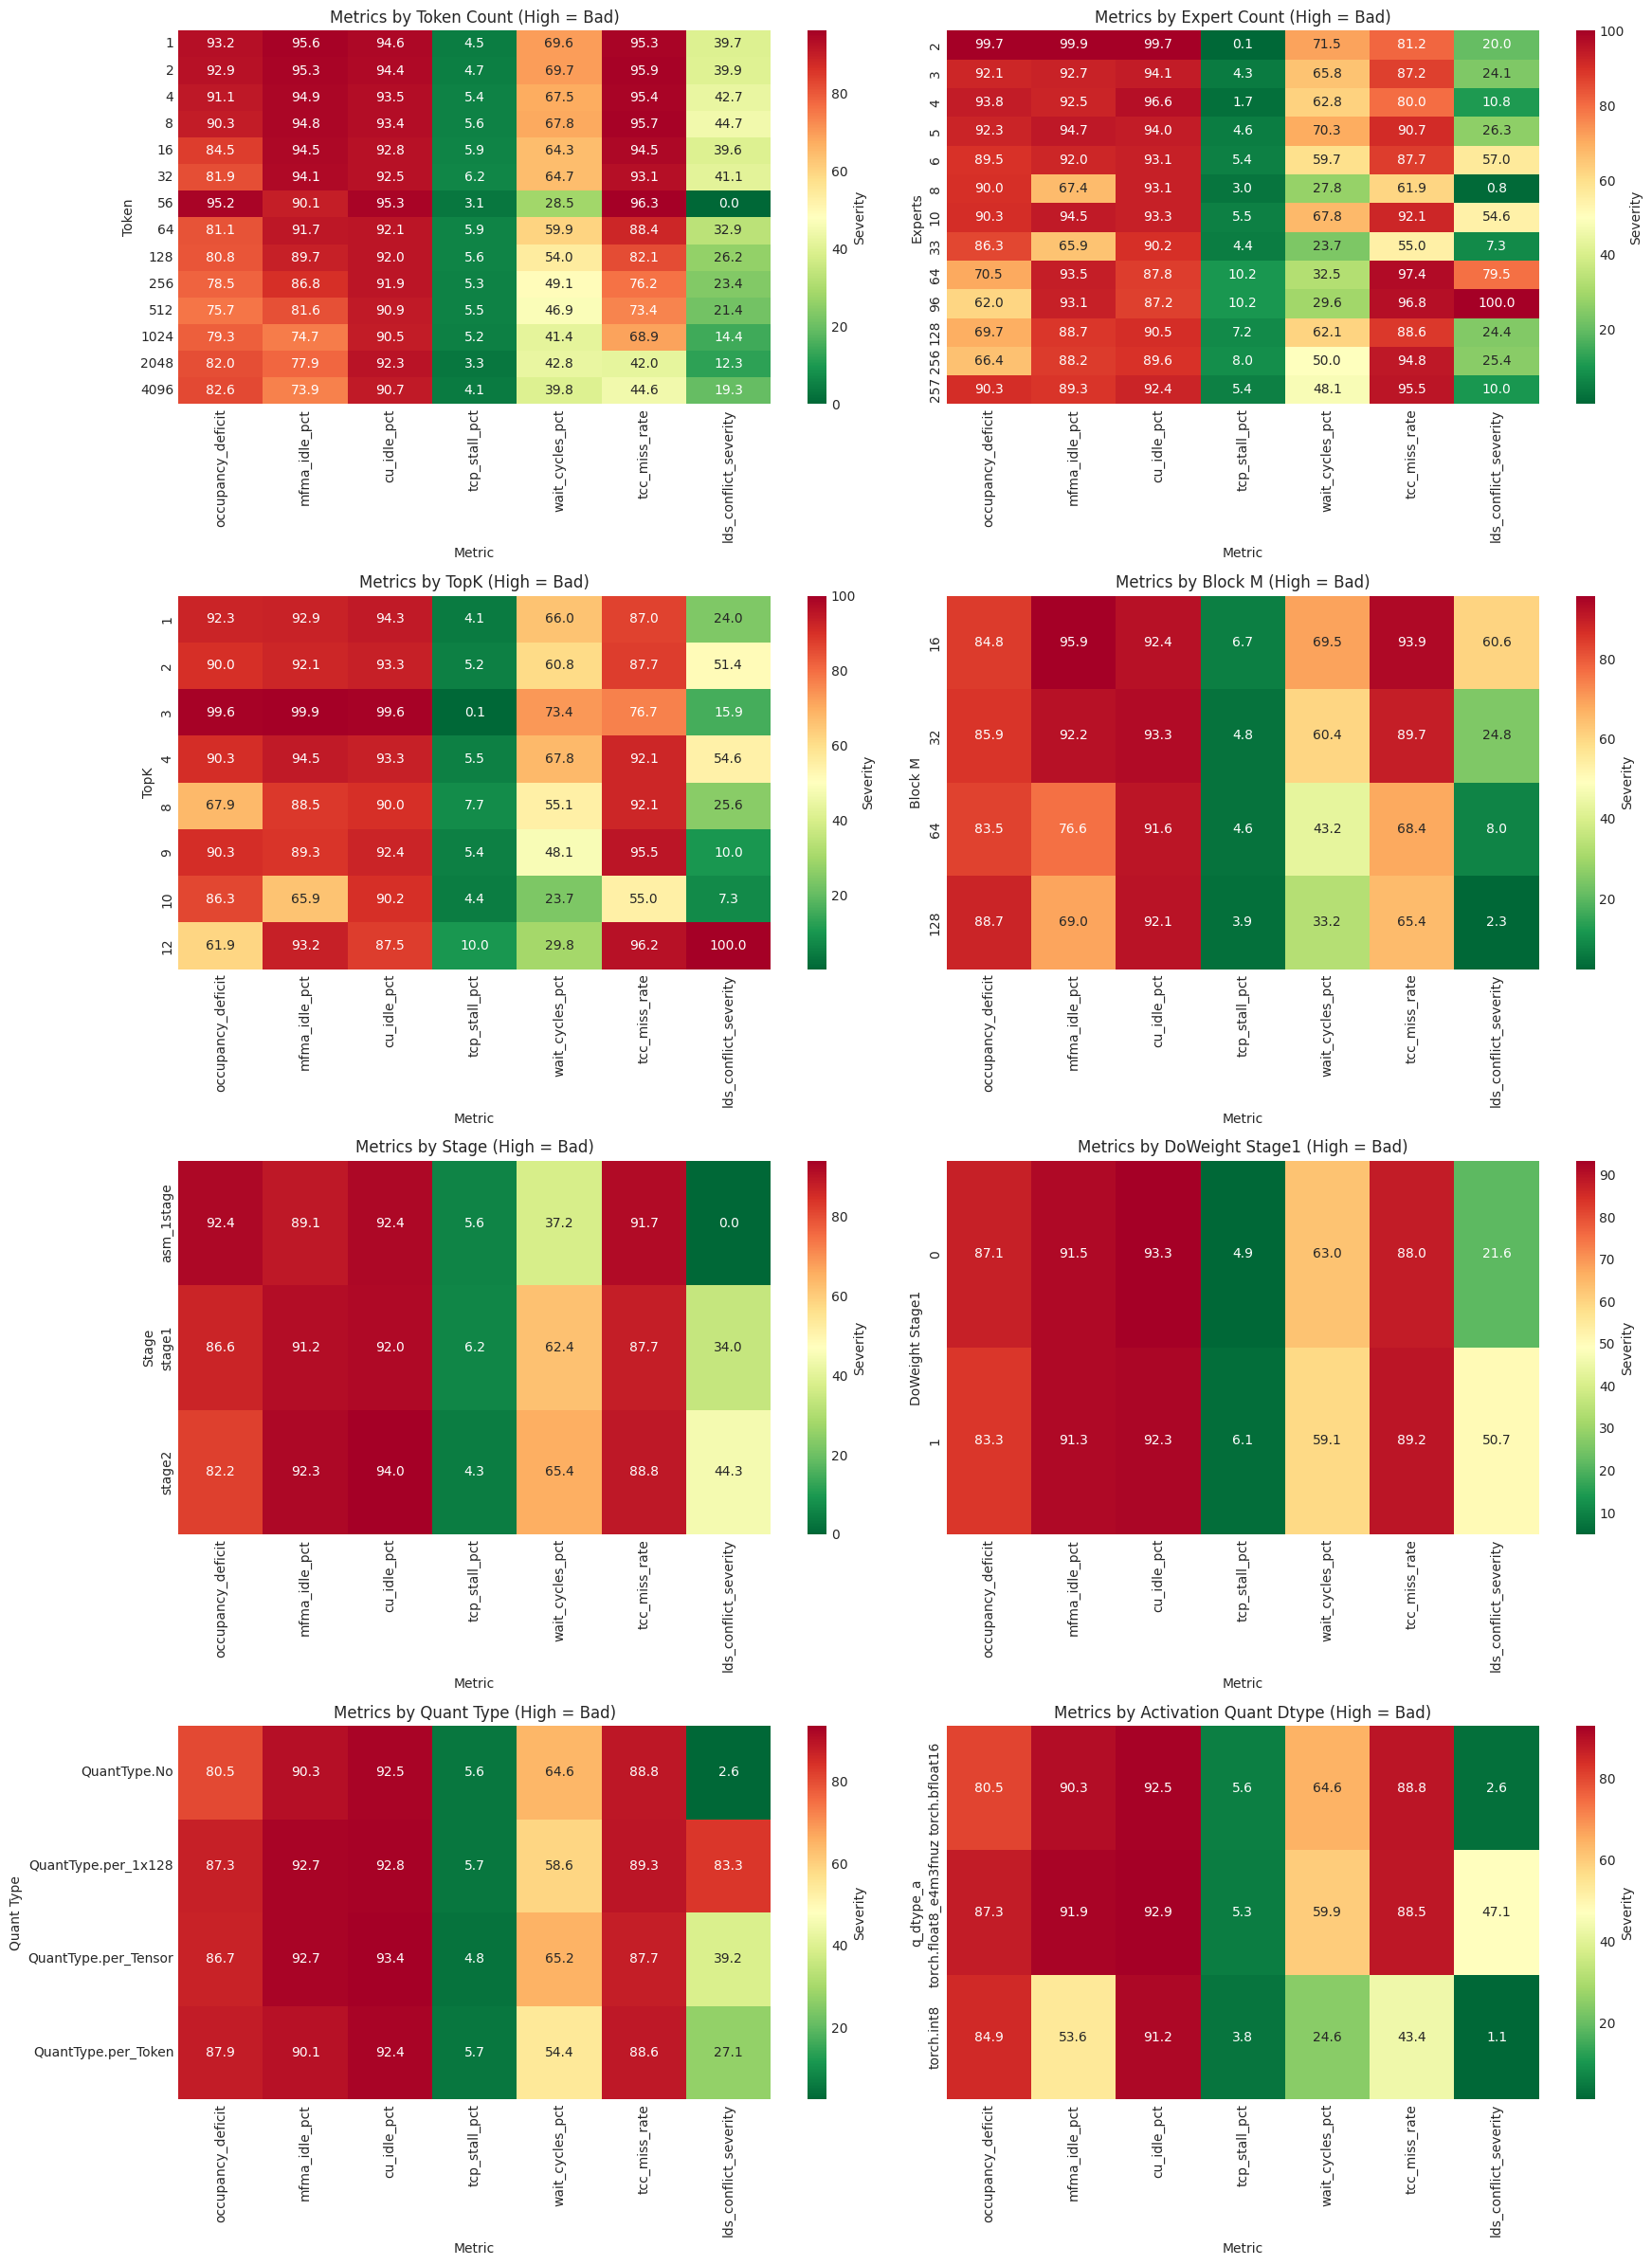

In [23]:
# 4b. Heatmaps by config parameters (all metrics: high = bad)
fig, axes = plt.subplots(4, 2, figsize=(18, 24))

# Use inverted metrics so high values consistently mean "bad" (red in RdYlGn_r)
heatmap_metrics = ["occupancy_deficit", "mfma_idle_pct", "cu_idle_pct",
                   "tcp_stall_pct", "wait_cycles_pct", "tcc_miss_rate", "lds_conflict_severity"]

# Heatmap by token count
token_data = df_n.groupby("token")[heatmap_metrics].mean()
sns.heatmap(token_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[0, 0],
            cbar_kws={"label": "Severity"})
axes[0, 0].set_title("Metrics by Token Count (High = Bad)")
axes[0, 0].set_xlabel("Metric")
axes[0, 0].set_ylabel("Token")

# Heatmap by number of experts
expert_data = df_n.groupby("expert")[heatmap_metrics].mean()
sns.heatmap(expert_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[0, 1],
            cbar_kws={"label": "Severity"})
axes[0, 1].set_title("Metrics by Expert Count (High = Bad)")
axes[0, 1].set_xlabel("Metric")
axes[0, 1].set_ylabel("Experts")

# Heatmap by topk
topk_data = df_n.groupby("topk")[heatmap_metrics].mean()
sns.heatmap(topk_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[1, 0],
            cbar_kws={"label": "Severity"})
axes[1, 0].set_title("Metrics by TopK (High = Bad)")
axes[1, 0].set_xlabel("Metric")
axes[1, 0].set_ylabel("TopK")

# Heatmap by block_m (tile size)
blockm_data = df_n.groupby("block_m")[heatmap_metrics].mean()
sns.heatmap(blockm_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[1, 1],
            cbar_kws={"label": "Severity"})
axes[1, 1].set_title("Metrics by Block M (High = Bad)")
axes[1, 1].set_xlabel("Metric")
axes[1, 1].set_ylabel("Block M")

# Heatmap by stage (decode vs prefill)
stage_data = df_n.groupby("stage")[heatmap_metrics].mean()
sns.heatmap(stage_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[2, 0],
            cbar_kws={"label": "Severity"})
axes[2, 0].set_title("Metrics by Stage (High = Bad)")
axes[2, 0].set_xlabel("Metric")
axes[2, 0].set_ylabel("Stage")

# Heatmap by doweight_stage1
doweight_data = df_n.groupby("doweight_stage1")[heatmap_metrics].mean()
sns.heatmap(doweight_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[2, 1],
            cbar_kws={"label": "Severity"})
axes[2, 1].set_title("Metrics by DoWeight Stage1 (High = Bad)")
axes[2, 1].set_xlabel("Metric")
axes[2, 1].set_ylabel("DoWeight Stage1")

# Heatmap by q_type (quantization type)
qtype_data = df_n.groupby("q_type")[heatmap_metrics].mean()
sns.heatmap(qtype_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[3, 0],
            cbar_kws={"label": "Severity"})
axes[3, 0].set_title("Metrics by Quant Type (High = Bad)")
axes[3, 0].set_xlabel("Metric")
axes[3, 0].set_ylabel("Quant Type")

# Heatmap by q_dtype_a (activation quant dtype)
qdtype_a_data = df_n.groupby("q_dtype_a")[heatmap_metrics].mean()
sns.heatmap(qdtype_a_data, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[3, 1],
            cbar_kws={"label": "Severity"})
axes[3, 1].set_title("Metrics by Activation Quant Dtype (High = Bad)")
axes[3, 1].set_xlabel("Metric")
axes[3, 1].set_ylabel("q_dtype_a")

plt.tight_layout()
plt.show()

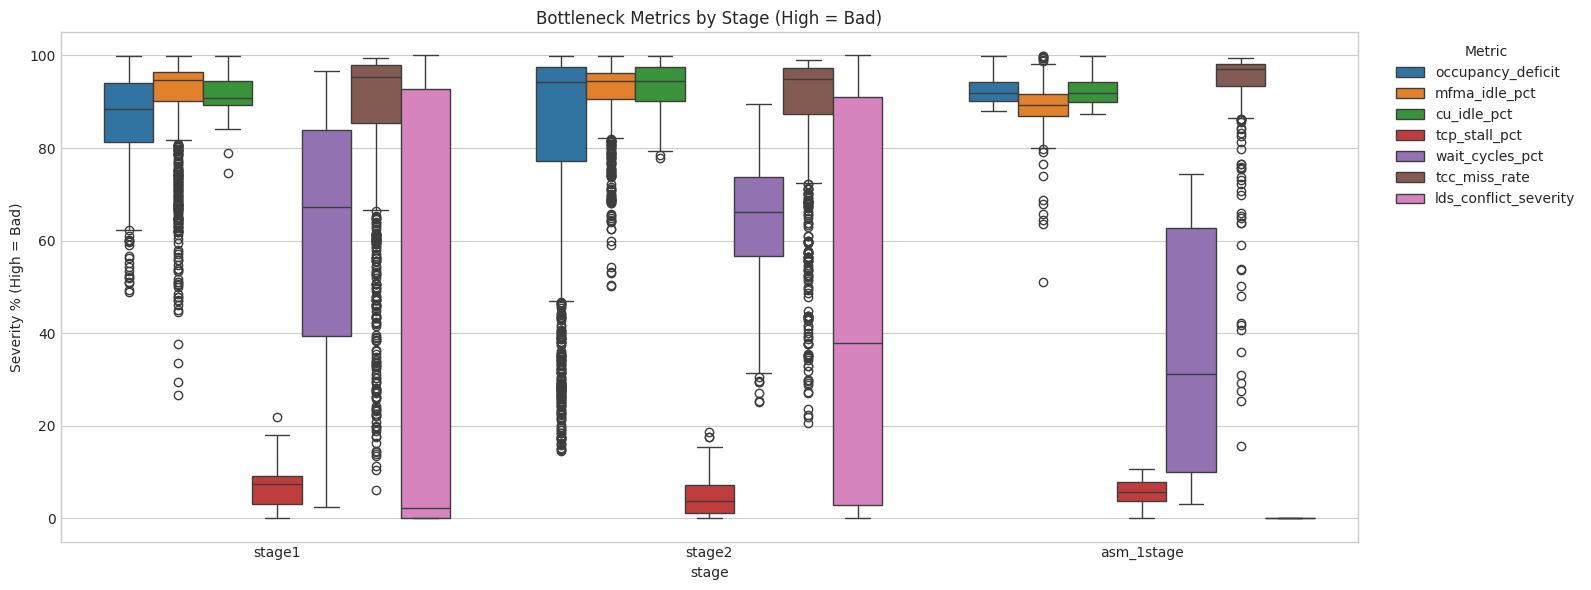

In [24]:
# 5. Box plot: all key metrics by stage (high values = bad)
fig, ax = plt.subplots(figsize=(16, 6))

# Box plot: all bottleneck metrics by stage (using deficit metrics for consistency)
stage_metrics = ["occupancy_deficit", "mfma_idle_pct", "cu_idle_pct",
                 "tcp_stall_pct", "wait_cycles_pct", "tcc_miss_rate", "lds_conflict_severity"]
df_stage = df_n.melt(id_vars=["stage"], 
                     value_vars=stage_metrics,
                     var_name="metric", value_name="value")
sns.boxplot(data=df_stage, x="stage", y="value", hue="metric", ax=ax)
ax.set_ylabel("Severity % (High = Bad)")
ax.set_title("Bottleneck Metrics by Stage (High = Bad)")
ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

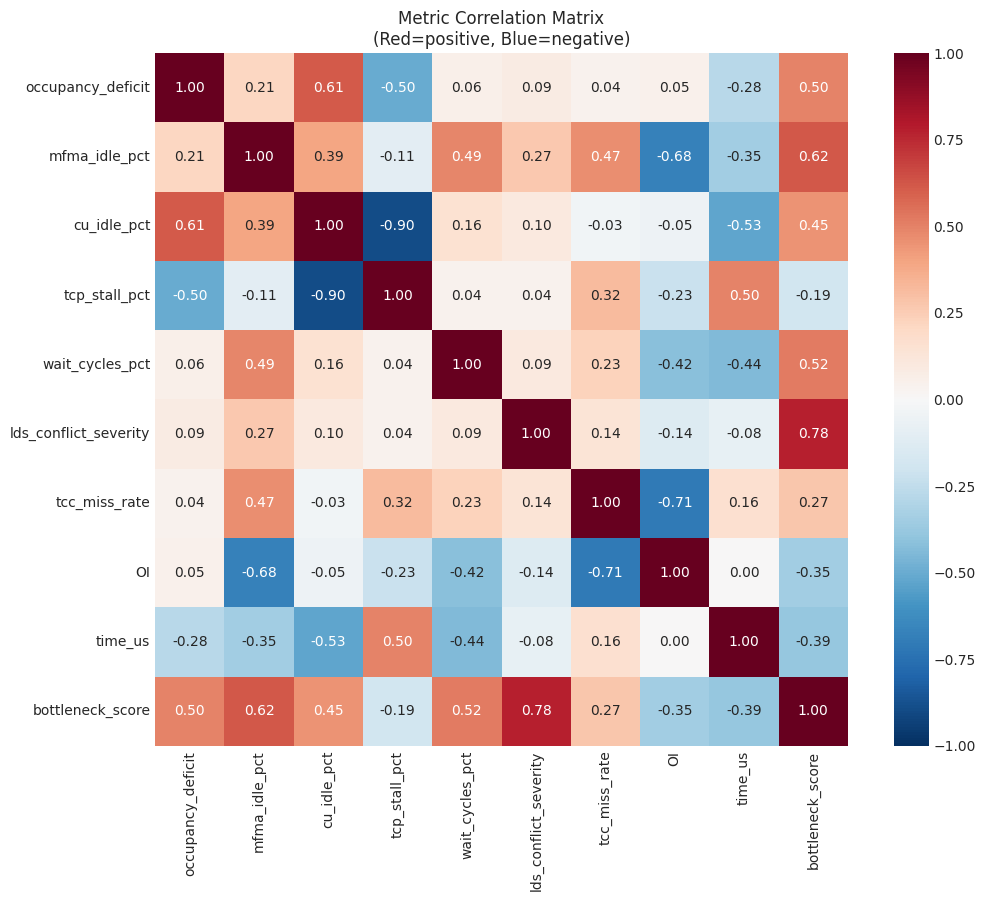

In [ ]:
# 6. Correlation heatmap - shows relationships between metrics (using deficit metrics)
fig, ax = plt.subplots(figsize=(11, 9))

corr_metrics = ["occupancy_deficit", "mfma_idle_pct", "cu_idle_pct", "tcp_stall_pct", "wait_cycles_pct", 
                "lds_conflict_severity", "tcc_miss_rate", "OI", "time_us", "bottleneck_score"]
corr_matrix = df_n[corr_metrics].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax,
            vmin=-1, vmax=1, square=True)
ax.set_title("Metric Correlation Matrix")
plt.tight_layout()
plt.show()

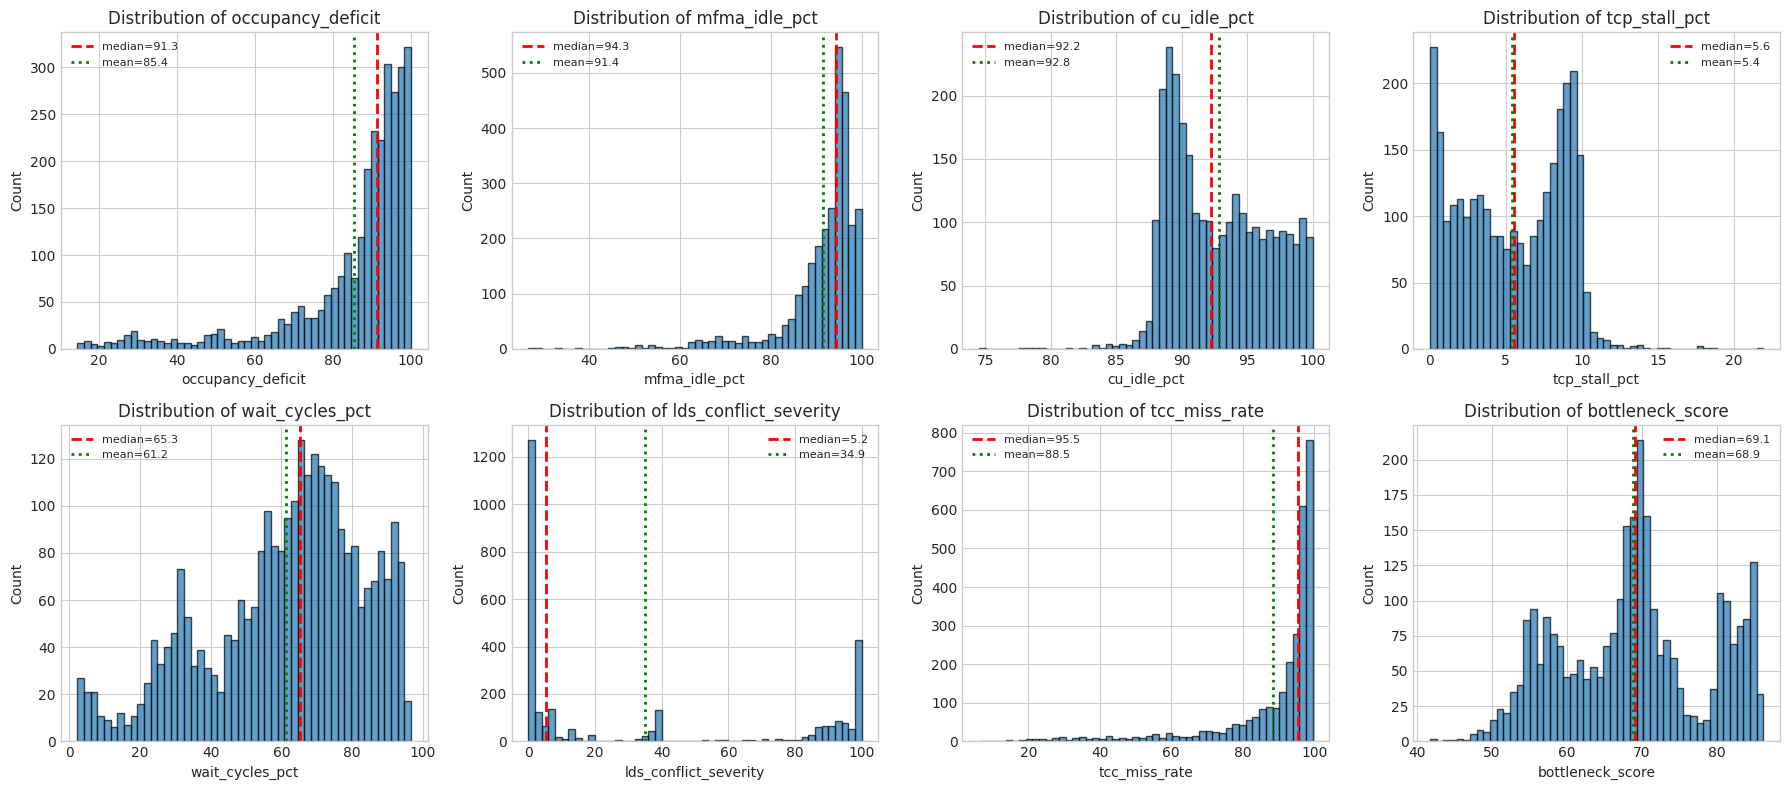

In [26]:
# 7. Metric distributions (histograms) - using deficit metrics (high = bad)
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

hist_metrics = ["occupancy_deficit", "mfma_idle_pct", "cu_idle_pct", "tcp_stall_pct",
                "wait_cycles_pct", "lds_conflict_severity", "tcc_miss_rate", "bottleneck_score"]

for i, m in enumerate(hist_metrics):
    ax = axes[i]
    data = df_n[m].dropna()
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'median={data.median():.1f}')
    ax.axvline(data.mean(), color='green', linestyle=':', linewidth=2, label=f'mean={data.mean():.1f}')
    ax.set_xlabel(m)
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)
    ax.set_title(f"Distribution of {m}")

plt.tight_layout()
plt.show()

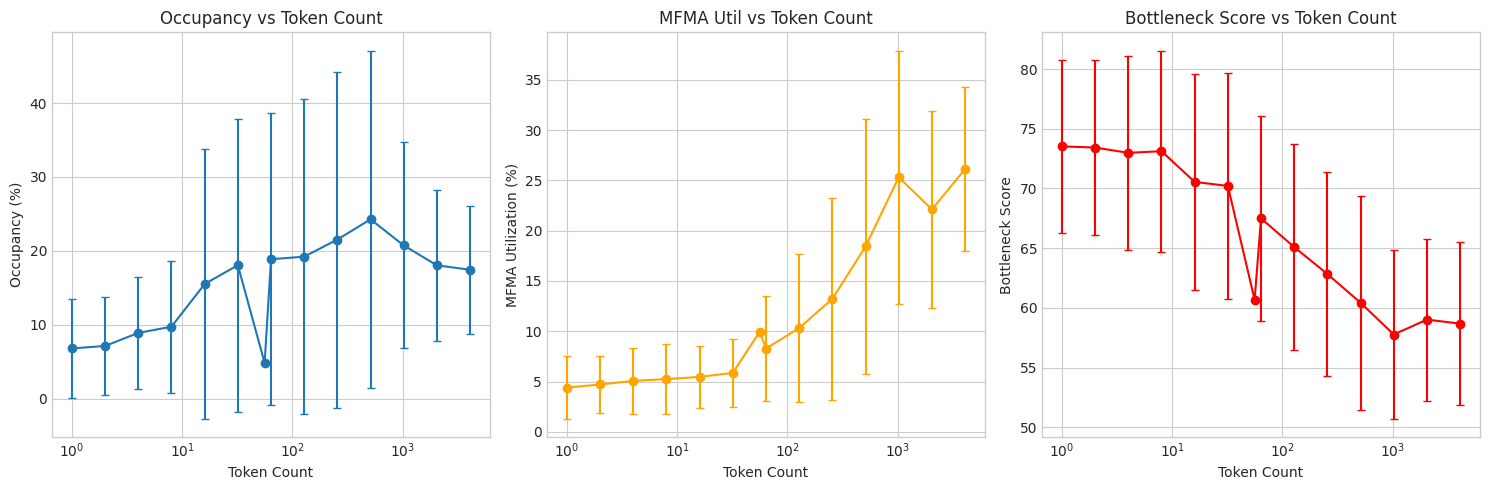

In [32]:
# 8. Bottleneck metrics vs token count (workload scaling)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get unique tokens sorted
token_order = sorted(df_n["token"].dropna().unique())

# Occupancy vs token
df_token = df_n.groupby("token").agg({
    "occupancy_pct": ["mean", "std"],
    "mfma_util_pct": ["mean", "std"],
    "bottleneck_score": ["mean", "std"]
}).reset_index()

axes[0].errorbar(df_token["token"], df_token["occupancy_pct"]["mean"], 
                 yerr=df_token["occupancy_pct"]["std"], marker='o', capsize=3)
axes[0].set_xlabel("Token Count")
axes[0].set_ylabel("Occupancy (%)")
axes[0].set_title("Occupancy vs Token Count")
axes[0].set_xscale("log")

axes[1].errorbar(df_token["token"], df_token["mfma_util_pct"]["mean"],
                 yerr=df_token["mfma_util_pct"]["std"], marker='o', capsize=3, color='orange')
axes[1].set_xlabel("Token Count")
axes[1].set_ylabel("MFMA Utilization (%)")
axes[1].set_title("MFMA Util vs Token Count")
axes[1].set_xscale("log")

axes[2].errorbar(df_token["token"], df_token["bottleneck_score"]["mean"],
                 yerr=df_token["bottleneck_score"]["std"], marker='o', capsize=3, color='red')
axes[2].set_xlabel("Token Count")
axes[2].set_ylabel("Bottleneck Score")
axes[2].set_title("Bottleneck Score vs Token Count")
axes[2].set_xscale("log")

plt.tight_layout()
plt.show()

/home/AMD/yashagar/.local/lib/python3.10/site-packages/matplotlib/colors.py:2243: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/AMD/yashagar/.local/lib/python3.10/site-packages/matplotlib/colors.py:2250: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/AMD/yashagar/.local/lib/python3.10/site-packages/matplotlib/ticker.py:563: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


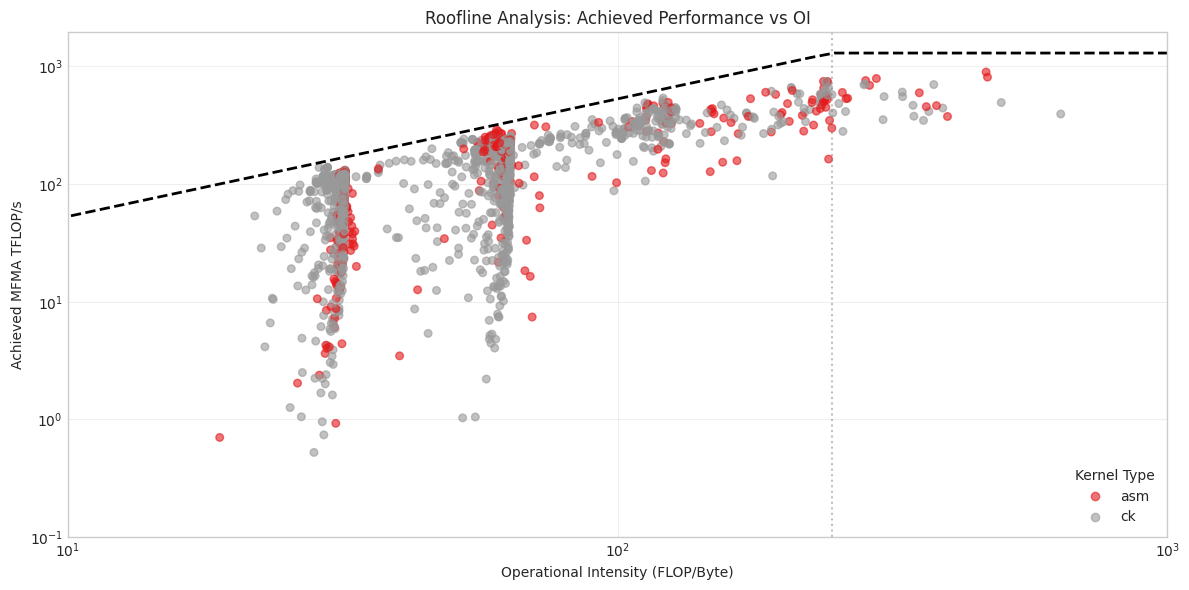

In [33]:
# 9. Roofline-style plot: Achieved TFLOP/s vs Operational Intensity
fig, ax = plt.subplots(figsize=(12, 6))

# MI300X theoretical peaks (approximate)
PEAK_TFLOPS = 1300  # FP16 peak
PEAK_BW = 5300      # GB/s HBM bandwidth
ridge_point = PEAK_TFLOPS * 1000 / PEAK_BW  # FLOP/Byte where compute = memory bound

# Plot roofline ceiling
oi_range = np.logspace(-1, 3, 100)
roofline = np.minimum(PEAK_TFLOPS, oi_range * PEAK_BW / 1000)
ax.plot(oi_range, roofline, 'k--', linewidth=2, label='Theoretical Roofline')
ax.axvline(ridge_point, color='gray', linestyle=':', alpha=0.5, label=f'Ridge Point (OI={ridge_point:.0f})')

# Plot actual kernel performance
scatter = ax.scatter(df_n["OI"], df_n["tflops_mfma"], 
                     c=df_n["kernel_type"].astype('category').cat.codes, 
                     cmap="Set1", alpha=0.6, s=30)

ax.set_xlabel("Operational Intensity (FLOP/Byte)")
ax.set_ylabel("Achieved MFMA TFLOP/s")
ax.set_title("Roofline Analysis: Achieved Performance vs OI")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10, 1000)
ax.set_ylim(0.1, PEAK_TFLOPS * 1.5)
ax.legend()
ax.grid(True, alpha=0.3)

# Add kernel type legend
handles, labels = scatter.legend_elements()
kernel_types = df_n["kernel_type"].astype('category').cat.categories.tolist()
ax.legend(handles, kernel_types, title="Kernel Type", loc="lower right")

plt.tight_layout()
plt.show()

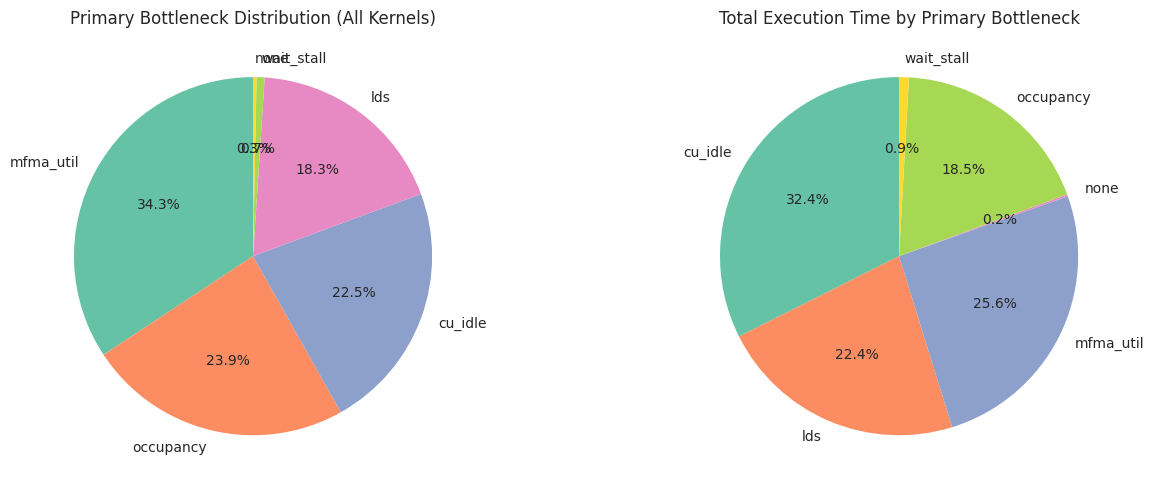

In [34]:
# 10. Bottleneck breakdown pie chart (overall)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall primary bottleneck distribution
bottleneck_dist = df_n["primary_bottleneck"].value_counts()
colors = plt.cm.Set2(range(len(bottleneck_dist)))
axes[0].pie(bottleneck_dist.values, labels=bottleneck_dist.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title("Primary Bottleneck Distribution (All Kernels)")

# Time contribution by bottleneck type
time_by_bottleneck = df_n.groupby("primary_bottleneck")["time_us"].sum()
axes[1].pie(time_by_bottleneck.values, labels=time_by_bottleneck.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title("Total Execution Time by Primary Bottleneck")

plt.tight_layout()
plt.show()

### Kernel-Type-Aware Analysis

Since LDS conflicts only affect CK kernels, we analyze each kernel type separately with the appropriate score.

In [35]:
# Kernel-type specific analysis with appropriate scores
print("=== Kernel-Type Specific Summary ===\n")

summary_data = []
for ktype in df_n["kernel_type"].unique():
    subset = df_n[df_n["kernel_type"] == ktype]
    top_bn = subset["primary_bottleneck"].value_counts().index[0]
    top_bn_pct = 100 * subset["primary_bottleneck"].value_counts().iloc[0] / len(subset)
    
    summary_data.append({
        "kernel_type": ktype,
        "count": len(subset),
        "top_bottleneck": f"{top_bn} ({top_bn_pct:.0f}%)",
        "avg_occupancy": subset["occupancy_pct"].mean(),
        "avg_mfma_util": subset["mfma_util_pct"].mean(),
        "avg_cu_busy": subset["cu_busy_pct"].mean(),
        "avg_lds_severity": subset["lds_conflict_severity"].mean(),
        "recommended_score": "bottleneck_score" if subset["lds_conflict_severity"].mean() > 10 else "score_no_lds"
    })
    
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()

# Top 10 worst kernels per type with appropriate score
print("=== Top 5 Worst Kernels by Type ===\n")
for ktype in df_n["kernel_type"].unique():
    subset = df_n[df_n["kernel_type"] == ktype]
    score_col = "bottleneck_score" if subset["lds_conflict_severity"].mean() > 10 else "score_no_lds"
    print(f"--- {ktype.upper()} (using {score_col}) ---")
    top5 = subset.nlargest(5, score_col)[["config_idx", "stage", "token", score_col, "primary_bottleneck"]]
    print(top5.to_string(index=False))
    print()

=== Kernel-Type Specific Summary ===

kernel_type  count  top_bottleneck  avg_occupancy  avg_mfma_util  avg_cu_busy  avg_lds_severity recommended_score
        asm    739 mfma_util (48%)      10.461665       9.491709     7.678111          0.000000      score_no_lds
         ck   2155 mfma_util (30%)      16.023391       8.258918     7.009867         46.843737  bottleneck_score

=== Top 5 Worst Kernels by Type ===

--- ASM (using score_no_lds) ---
 config_idx  stage  token  score_no_lds primary_bottleneck
        448 stage1      1     81.891315          mfma_util
        471 stage1      2     81.727271          mfma_util
        447 stage1      1     81.667208          mfma_util
        443 stage1      1     81.657264          mfma_util
        459 stage1      2     81.592808          mfma_util

--- CK (using bottleneck_score) ---
 config_idx  stage  token  bottleneck_score primary_bottleneck
       1002 stage1      8         86.194151                lds
       1066 stage1      2       

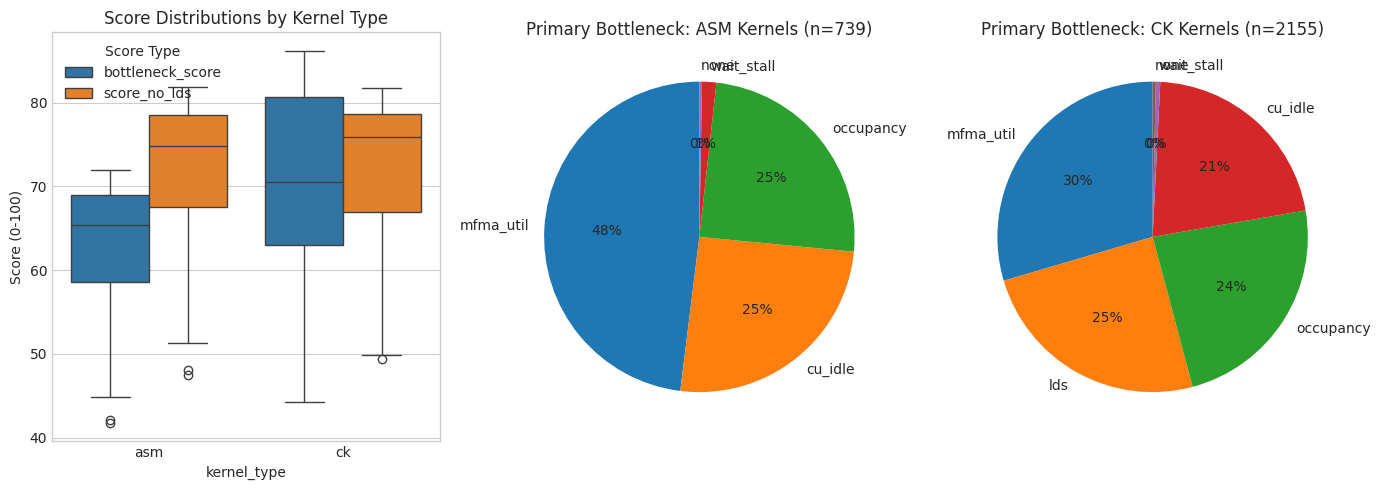

In [31]:
# Visualize score comparison by kernel type
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# 1. Score distributions by kernel type
df_scores = df_n.melt(id_vars=["kernel_type"], value_vars=["bottleneck_score", "score_no_lds"],
                      var_name="score_type", value_name="score")
sns.boxplot(data=df_scores, x="kernel_type", y="score", hue="score_type", ax=axes[0])
axes[0].set_title("Score Distributions by Kernel Type")
axes[0].set_ylabel("Score (0-100)")
axes[0].legend(title="Score Type")

# 2. Primary bottleneck pie: ASM kernels
asm_data = df_n[df_n["kernel_type"] == "asm"]
asm_bn = asm_data["primary_bottleneck"].value_counts()
axes[1].pie(asm_bn.values, labels=asm_bn.index, autopct='%1.0f%%', startangle=90)
axes[1].set_title(f"Primary Bottleneck: ASM Kernels (n={len(asm_data)})")

# 3. Primary bottleneck pie: CK kernels
ck_data = df_n[df_n["kernel_type"] == "ck"]
ck_bn = ck_data["primary_bottleneck"].value_counts()
axes[2].pie(ck_bn.values, labels=ck_bn.index, autopct='%1.0f%%', startangle=90)
axes[2].set_title(f"Primary Bottleneck: CK Kernels (n={len(ck_data)})")

plt.tight_layout()
plt.show()